In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pycocotools

In [3]:
import zipfile

zip_file_path = '/content/drive/MyDrive/OSCD.zip'
dataset_folder = '/content/drive/MyDrive/OSCD/'

if len(os.listdir(dataset_folder)) == 0:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(dataset_folder)

  print(f"Unzipped to: {dataset_folder}")

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_folder = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/images/train2017')
val_folder = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/images/val2017')
train_annotation = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/annotations/instances_train2017.json')
val_annotation = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/annotations/instances_val2017.json')

In [5]:
import torch
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
from PIL import Image
from torchvision.tv_tensors import Mask
from torchvision.transforms.functional import to_tensor
from skimage.draw import polygon as sk_polygon

class OSCDDataset(CocoDetection):
    def __init__(self, img_folder, ann_file):
        super().__init__(img_folder, ann_file, transforms=None)

    def __getitem__(self, idx):
        img, anns = super().__getitem__(idx)

        labels = []
        areas = []
        iscrowd = []
        masks = []
        boxes = []

        for ann in anns:
            x, y, w, h = list(map(int, ann['bbox']))
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
            areas.append(ann['area'])
            iscrowd.append(ann['iscrowd'])
            mask = self.get_mask(ann['segmentation'], img.size[1], img.size[0])
            masks.append(mask)
        labels = torch.tensor(labels, dtype=torch.int64)
        areas = torch.tensor(areas, dtype=torch.float32)
        iscrowd = torch.tensor(iscrowd, dtype=torch.uint8)
        boxes = torch.tensor(boxes, dtype=torch.int64)
        masks = torch.stack(masks, dim=0)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": areas,
            "iscrowd": iscrowd,
            "masks": Mask(masks),
        }
        img = to_tensor(img)
        return img, target

    def get_mask(self, segmentation, height, width):
        mask = torch.zeros((height, width), dtype=torch.bool)
        poly_x = segmentation[0][::2]
        poly_y = segmentation[0][1::2]
        rr, cc = sk_polygon(poly_y, poly_x, shape=(height, width))
        mask[rr, cc] = 1
        return mask


In [6]:
train_dataset = OSCDDataset(train_folder, train_annotation)
val_dataset = OSCDDataset(val_folder, val_annotation)

loading annotations into memory...
Done (t=3.42s)
creating index...
index created!
loading annotations into memory...
Done (t=0.97s)
creating index...
index created!


In [7]:
def collate_fn(batch):
    images, targets = list(zip(*batch))
    return images, targets
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
# print(model)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:05<00:00, 33.7MB/s]


In [17]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [23]:

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


In [24]:
train_dataset = next(iter(train_loader))
images_list = train_dataset[0]
targets_list = train_dataset[1]

In [25]:
images = [image.to(device) for image in images_list]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets_list]

In [26]:
model.to(device)
print("model")

model


In [27]:
output = model(images, targets)

In [28]:
print(output)

{'loss_classifier': tensor(0.5934, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(1.0363, grad_fn=<DivBackward0>), 'loss_mask': tensor(3.2215, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(2.0745, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.2344, grad_fn=<DivBackward0>)}


In [30]:
model.eval()
print("start eval")

start eval


In [34]:
preds = model(images)

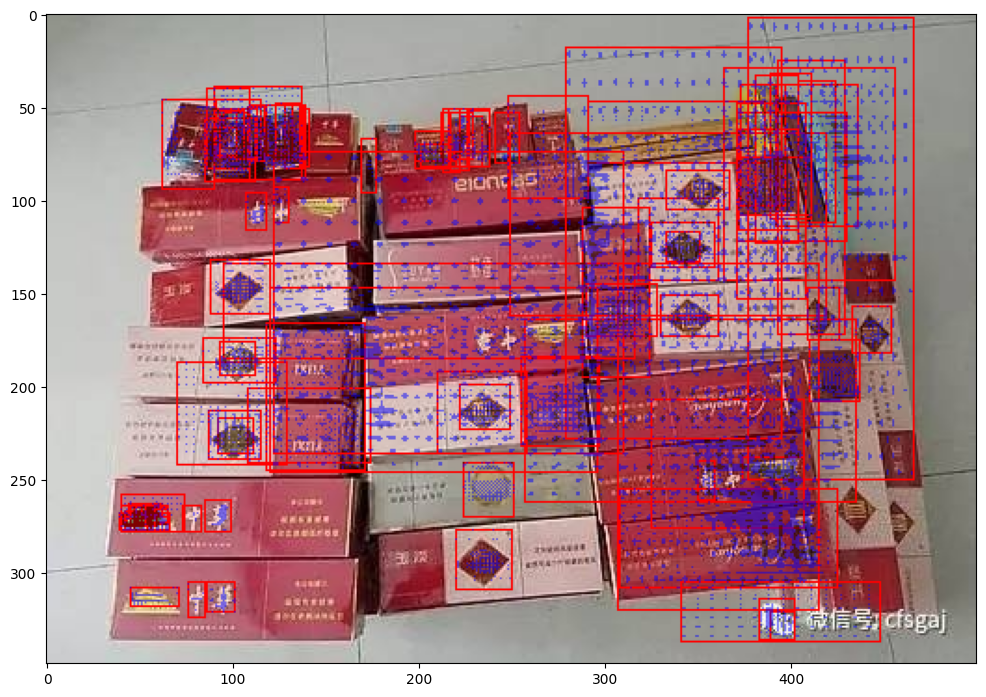

In [37]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

img = images[0]
pred = preds[0]
pred_boxes = pred["boxes"]
pred_labels = pred["labels"]

plt_img = draw_bounding_boxes(img, pred_boxes, colors="red")
masks = (pred["masks"] > 0.7).squeeze(1)
plt_img = draw_segmentation_masks(plt_img, masks, alpha=0.5, colors="blue")
plt.figure(figsize=(12, 12))
plt.imshow(plt_img.permute(1, 2, 0))